In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error


C:\Users\Wilson\AppData\Local\Temp\ipykernel_18436\3531775907.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load the dataset
file_path = 'result.csv'
data = pd.read_csv(file_path)

# Forward-fill the missing 'Bid' values
data['Bid'] = data['Bid'].fillna(method='ffill').dropna()

# Convert 'Timestamp' to a datetime type, setting an arbitrary start date
data['Timestamp'] = pd.to_timedelta(data['Timestamp'], unit='s') + pd.Timestamp('2025-01-02 00:00')
data.set_index('Timestamp', inplace=True)



# Resampling to a consistent frequency, using forward fill for missing values
data = data['Bid'].asfreq('S', method='ffill')



C:\Users\Wilson\AppData\Local\Temp\ipykernel_18436\960170881.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Bid'] = data['Bid'].fillna(method='ffill').dropna()
C:\Users\Wilson\AppData\Local\Temp\ipykernel_18436\960170881.py:15: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data = data['Bid'].asfreq('S', method='ffill')


In [ ]:
# Split the data into training and testing sets (80% train, 20% test)
split_point = int(len(data) * 0.8)
train_data, test_data = data[:split_point], data[split_point:]

# Ensure the indices are monotonically increasing and remove any duplicates
train_data = train_data.sort_index()
test_data = test_data.sort_index()
train_data = train_data[~train_data.index.duplicated(keep='first')]

# Initialize the history with the training data
history = train_data.copy()

# Define the frequency of model updates
update_frequency = 5

# Preallocate space for predictions for performance optimization
predictions = [None] * len(test_data)

# Start rolling forecast with updates every 5 steps
for t in range(0, len(test_data), update_frequency):
    # Fit the ARIMA model on the current history
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    
    # Make predictions for the next 5 steps
    next_steps_predictions = model_fit.forecast(steps=update_frequency)
    
    # Store the predictions
    if t + update_frequency < len(test_data):
        predictions[t:t+update_frequency] = next_steps_predictions
    else:
        predictions[t:] = next_steps_predictions[:len(test_data)-t]
    
    # Update the history with the new observations
    if t + update_frequency < len(test_data):
        new_history = test_data[t:t+update_frequency]
        history = pd.concat([history, new_history])
    print(f'Forecast step: {t}')

# Convert predictions to a Series for easy plotting
predictions_series = pd.Series(predictions, index=test_data.index)



Forecast step: 0
Forecast step: 5
Forecast step: 10
Forecast step: 15
Forecast step: 20
Forecast step: 25
Forecast step: 30
Forecast step: 35
Forecast step: 40
Forecast step: 45
Forecast step: 50
Forecast step: 55
Forecast step: 60
Forecast step: 65
Forecast step: 70
Forecast step: 75
Forecast step: 80
Forecast step: 85
Forecast step: 90
Forecast step: 95
Forecast step: 100
Forecast step: 105
Forecast step: 110
Forecast step: 115
Forecast step: 120
Forecast step: 125
Forecast step: 130
Forecast step: 135
Forecast step: 140
Forecast step: 145
Forecast step: 150
Forecast step: 155
Forecast step: 160
Forecast step: 165
Forecast step: 170
Forecast step: 175
Forecast step: 180
Forecast step: 185
Forecast step: 190
Forecast step: 195
Forecast step: 200
Forecast step: 205
Forecast step: 210
Forecast step: 215
Forecast step: 220
Forecast step: 225
Forecast step: 230
Forecast step: 235
Forecast step: 240
Forecast step: 245
Forecast step: 250
Forecast step: 255
Forecast step: 260
Forecast step: 

Test RMSE: 7.479443748247678


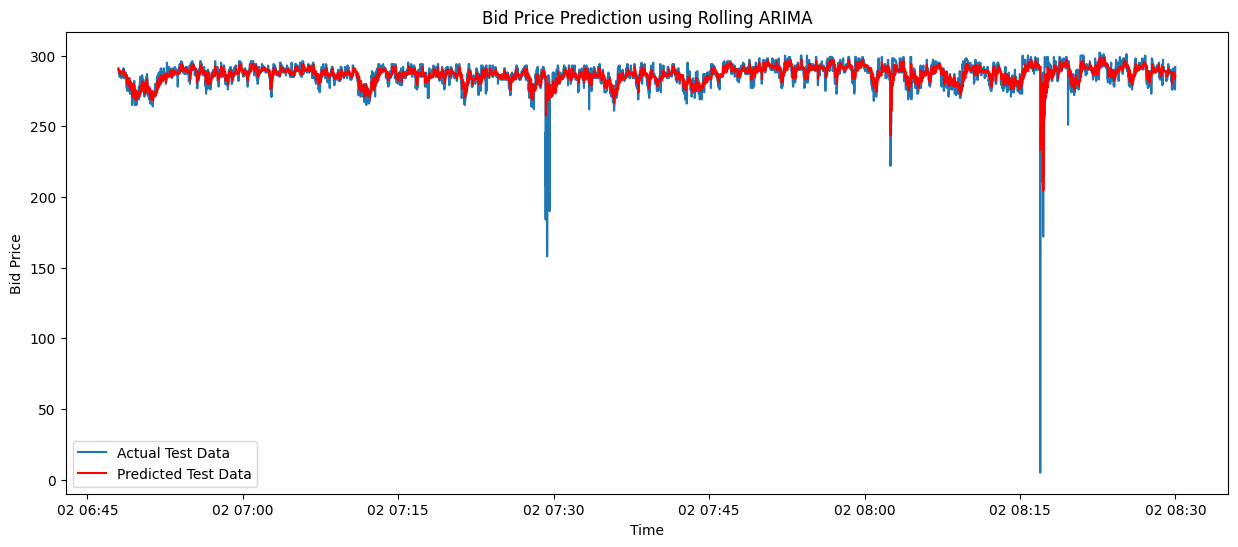

In [ ]:
# Calculate the RMSE for the predictions
rmse = np.sqrt(mean_squared_error(test_data, predictions_series))
print(f"Test RMSE: {rmse}")

# Plotting the results
plt.figure(figsize=(15, 6))
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(predictions_series.index, predictions_series, label='Predicted Test Data', color='red')
plt.legend()
plt.title('Arima Bid Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Bid Price')
plt.show()
